# Exclusion Zone Proof of Concept
---
The purpose of this notebook is to evaluate the use of exclusion zones for improving cell size measurements. Exclusion zones are directionally-resolved areas of the soot foil image where a researcher is relatively confident that any adjacent detonation boundaries are separated by more than one cell size, e.g. due to foil damage or inconsistent soot tracks.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp

from funcs.dir import d_drive
from funcs.post_processing.images.soot_foil.deltas import get_px_deltas_from_lines, Shot

sns.set_palette("colorblind")

Read in spatial calibrations and initialize shot objects

In [2]:
df_spatial = pd.read_csv(
    os.path.join(d_drive, "Data", "Processed", "Soot Foil", "spatial_calibrations.csv")
)
shots_to_test = (
    Shot("2020-12-10", 5),
    Shot("2020-12-10", 6),
)

Collect measurements

In [3]:
for shot in shots_to_test:
    shot_dir = os.path.join(
        d_drive, "Data", "Processed", "Soot Foil", "foil images", shot.dir_name
    )

    if not os.path.exists(shot_dir):
        warnings.warn(f"{shot_dir} does not exist; skipping")
        continue

    for direction in (0, 1):
        img_path = os.path.join(shot_dir, f"dir{direction}.png")
        mask_path = os.path.join(shot_dir, f"trash{direction}.png")
        deltas_with_exclusion = get_px_deltas_from_lines(
            img_path, mask_path, apply_uncertainty=False
        )
        deltas_without_exclusion = get_px_deltas_from_lines(
            img_path, None, apply_uncertainty=False
        )
    shot.deltas_with_exclusion = deltas_with_exclusion
    shot.deltas_without_exclusion = deltas_without_exclusion
    this_spatial = df_spatial[
        (df_spatial["date"] == shot.date) & (df_spatial["shot"] == shot.shot_no)
    ]
    shot.px_to_mm = (this_spatial["delta_mm"] / this_spatial["delta_px"]).values[0]

Calculate and plot cell sizes from measurements

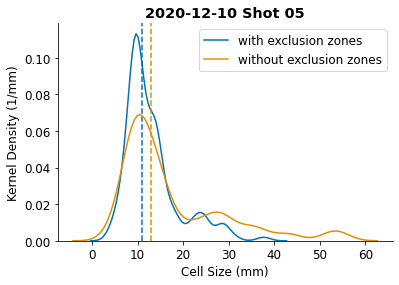


2020-12-10 Shot 05
------------------
with exclusion:
    10.94 mm
    1135 measurements
without exclusion:
    13.01 mm
    1395 measurements
difference:
    2.08 mm (15.96 %)
    260 measurements (18.64 %)




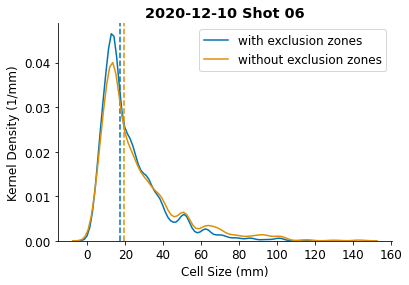


2020-12-10 Shot 06
------------------
with exclusion:
    17.32 mm
    13695 measurements
without exclusion:
    19.50 mm
    14983 measurements
difference:
    2.18 mm (11.19 %)
    1288 measurements (8.60 %)




In [4]:
for shot in shots_to_test:
    with_exclusion_px = unp.nominal_values(shot.deltas_with_exclusion)
    without_exclusion_px = unp.nominal_values(shot.deltas_without_exclusion)

    with_exclusion_mm = with_exclusion_px * shot.px_to_mm
    without_exclusion_mm = without_exclusion_px * shot.px_to_mm

    n_with = len(with_exclusion_mm)
    n_without = len(without_exclusion_mm)
    difference_n = np.abs(n_with - n_without)
    difference_n_pct = 100 * difference_n / n_without
    lambda_with_mm = np.median(with_exclusion_mm)
    lambda_without_mm = np.median(without_exclusion_mm)
    difference_mm = np.abs(lambda_with_mm - lambda_without_mm)
    difference_mm_pct = 100 * difference_mm / lambda_without_mm

    fig, ax = plt.subplots()
    ax.set_title(str(shot), weight="bold")
    sns.kdeplot(
        with_exclusion_mm,
        ax=ax,
        label="with exclusion zones",
    )
    plt.axvline(
        lambda_with_mm,
        color=f"C0",
        ls="--",
    )
    sns.kdeplot(
        without_exclusion_mm,
        ax=ax,
        label="without exclusion zones",
    )
    plt.axvline(
        lambda_without_mm,
        color=f"C1",
        ls="--",
    )
    ax.set_ylabel("Kernel Density (1/mm)")
    ax.set_xlabel("Cell Size (mm)")
    sns.despine()
    plt.show()

    print()
    print(shot)
    print("-" * len(shot))
    print("with exclusion:")
    print(f"    {lambda_with_mm:.2f} mm")
    print(f"    {n_with} measurements")
    print("without exclusion:")
    print(f"    {lambda_without_mm:.2f} mm")
    print(f"    {n_without} measurements")
    print("difference:")
    print(f"    {difference_mm:.2f} mm ({difference_mm_pct:.2f} %)")
    print(f"    {difference_n:d} measurements ({difference_n_pct:.2f} %)")
    print()
    print()

In Shot 05 the difference from using exclusion zones is ~20%, and it looks like a qualitatively better measurement (i.e. more representative of the distribution). In Shot 06 the difference from using exclusion zones is ~10%, although the difference is qualitatively no different. This is a smart move going forward, and the only drawback that I can see is that measurements are slow to collect, which was already an issue with the previous method. Two potential ways to speed this up would be:

1) Use of `numba` to speed up the for loops, or
2) Use of a faster language such as rust for the looping.